## Deep convolution Generative adversarial net (DCGAN) Example, MNIST

- 1장의 최적의 이미지 선정해서 제출


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 27 15:55:29 2017

@author: HQ
"""

import os,random
import numpy as np

from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
K.image_data_format()
#from IPython import display
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets import mnist


## plotting function
### ploting
def plot_gen(n_ex=16,dim=(4,4), figsize=(5,5)):
    noise = np.random.normal(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)
    generated_images = ((generated_images * 127.5) + 127.5).astype(np.uint8)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]

        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_real(n_ex=16,dim=(4,4), figsize=(5,5)):

    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]
    generated_images = ((generated_images * 127.5) + 127.5).astype(np.uint8)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_loss(losses):
#        display.clear_output(wait=True)
#        display.display(plt.gcf())
        plt.figure(figsize=(6,4))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = (X_train.astype(np.float32) - 127.5)/127.5 ## -1 ~ 1 scaleing)
X_test = (X_test.astype(np.float32) - 127.5)/127.5

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

print(X_train.shape)

## model
## generator

## g_input = (?,100)
g_input = Input(shape = (100,))

H = Dense(128*7*7)(g_input)
H = LeakyReLU(0.2)(H)
H = BatchNormalization()(H)

H = Reshape([7,7,128])(H) # dimension setting

H = UpSampling2D()(H)
H = Conv2D(64,(5,5),padding='same')(H)
H = LeakyReLU(0.2)(H)
H = BatchNormalization()(H)

H = UpSampling2D()(H)
H = Conv2D(32,(3,3),padding='same')(H)
H = LeakyReLU(0.2)(H)
H = BatchNormalization()(H)

H = Conv2D(1,(3,3),padding='same')(H)
g_V = Activation('tanh')(H)
## g_output = (1,28,28,1)

generator = Model(inputs = g_input, outputs = g_V)
generator.compile(loss = 'binary_crossentropy', optimizer = Adam())

## discriminator
## d_input = (?,28,28,1)

d_input = Input(shape = (X_train.shape[1:]))

H = Conv2D(32,(3,3),strides=(2,2),padding='same')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(0.3)(H)

H = Conv2D(64,(3,3),strides=(2,2), padding='same')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(0.3)(H)

H = Conv2D(128,(3,3),strides=(2,2), padding='same')(H)
H = LeakyReLU(0.2)(H)

H = Flatten()(H)
H = Dense(1)(H)
d_V = Activation('sigmoid')(H)
## d_output = (?,1)

discriminator = Model(inputs = d_input, outputs = d_V)
discriminator.compile(loss = 'binary_crossentropy', optimizer= Adam())



discriminator.trainable = False
GAN_input= Input(shape = (100,))
gen_sample = generator(GAN_input)
GAN_output = discriminator(gen_sample)

GAN = Model(inputs = GAN_input, outputs = GAN_output)
GAN.compile(loss = 'binary_crossentropy', optimizer=Adam())


##############
## train GAN model

epoch = 100
batch_size = 128
freq = 1

batch_count = X_train.shape[0]//batch_size

losses = {"d":[], "g":[]}
for i in range(epoch):
    for j in tqdm(range(batch_count)):
        noise_input = np.random.normal(0, 1, size= (batch_size, 100))

        real_image = X_train[np.random.randint(0, X_train.shape[0],
                                                size = batch_size)]

        fake_image = generator.predict(noise_input, batch_size=batch_size)

        X = np.concatenate([fake_image,real_image])
        y_discriminator = [0]*batch_size + [1] * batch_size

        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y_discriminator)
        losses["d"].append(d_loss)


        noise_input = np.random.normal(0, 1, size= (batch_size, 100))
        y_generator = [1] * batch_size
        discriminator.trainable = False
        g_loss = GAN.train_on_batch(noise_input, y_generator)
        losses["g"].append(g_loss)

    if i%freq==freq-1:
       plot_loss(losses)
       plot_gen()





plot_gen()
plot_real()

(60000, 28, 28, 1)


  0%|          | 0/468 [00:00<?, ?it/s]

Using TensorFlow backend.


(60000, 28, 28, 1)


100%|██████████| 468/468 [00:23<00:00, 20.10it/s]


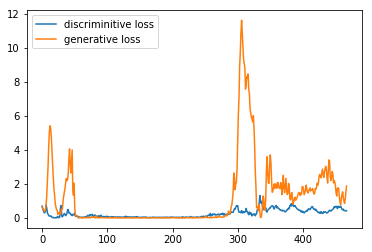

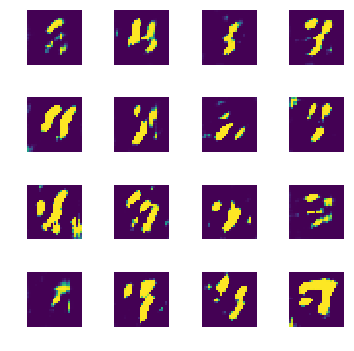

100%|██████████| 468/468 [00:22<00:00, 20.64it/s]


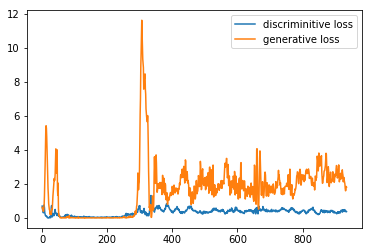

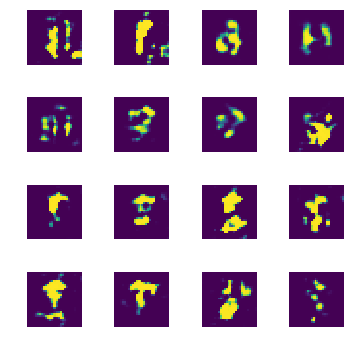

100%|██████████| 468/468 [00:23<00:00, 20.33it/s]


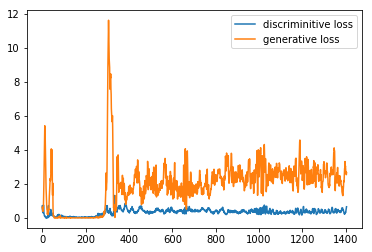

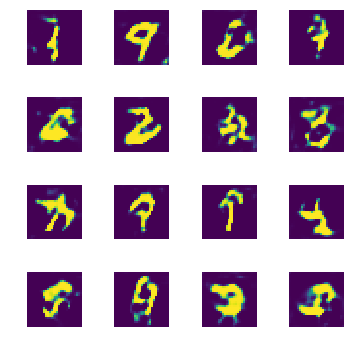

100%|██████████| 468/468 [00:23<00:00, 20.77it/s]


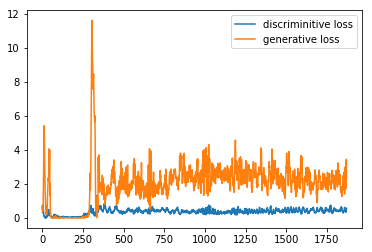

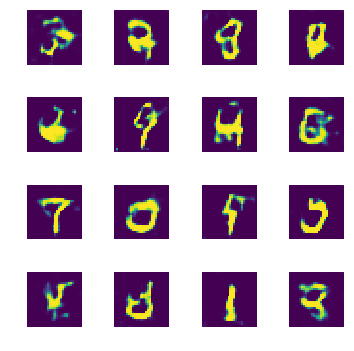

100%|██████████| 468/468 [00:23<00:00, 20.13it/s]


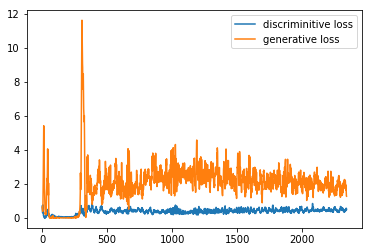

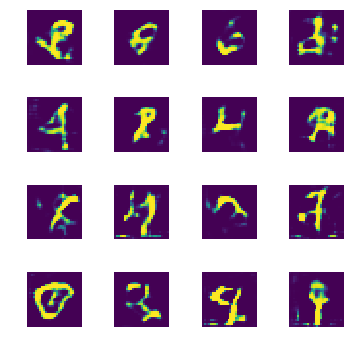

100%|██████████| 468/468 [00:22<00:00, 20.58it/s]


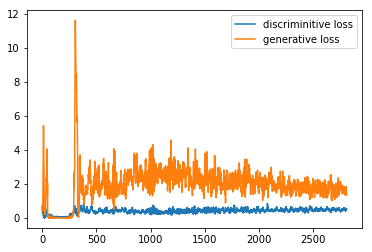

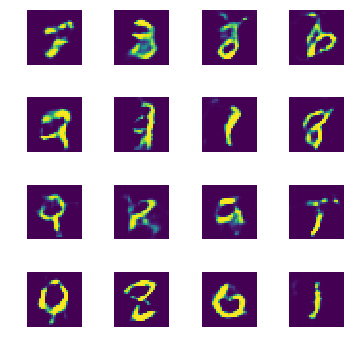

100%|██████████| 468/468 [00:22<00:00, 20.48it/s]


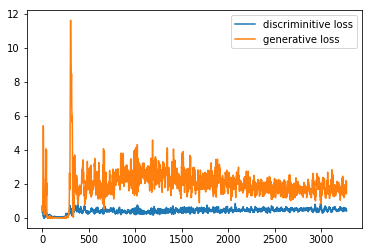

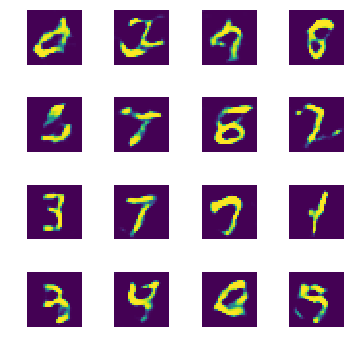

100%|██████████| 468/468 [00:22<00:00, 20.91it/s]


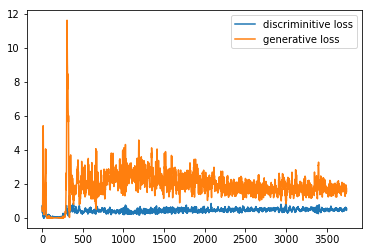

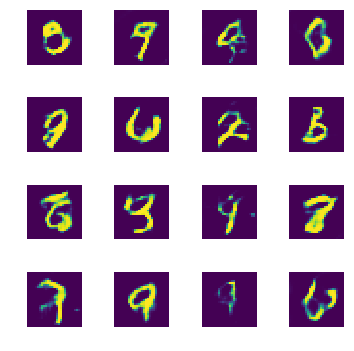

100%|██████████| 468/468 [00:22<00:00, 21.05it/s]


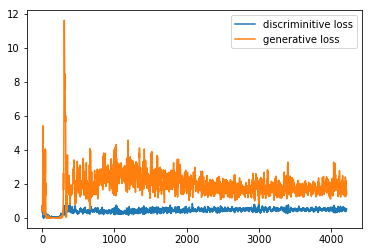

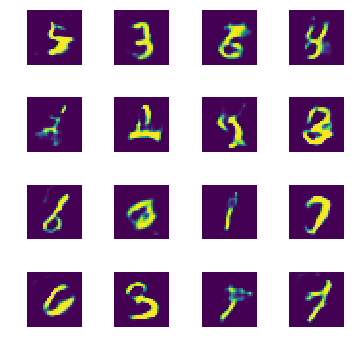

100%|██████████| 468/468 [00:22<00:00, 21.04it/s]


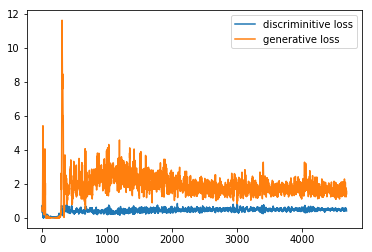

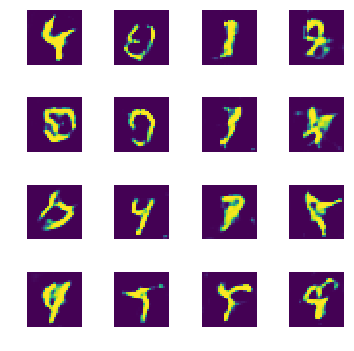

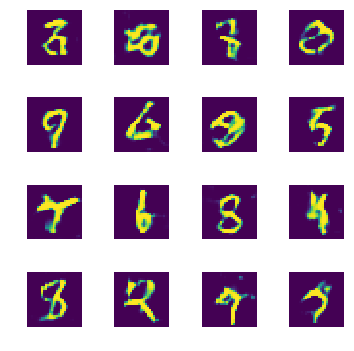

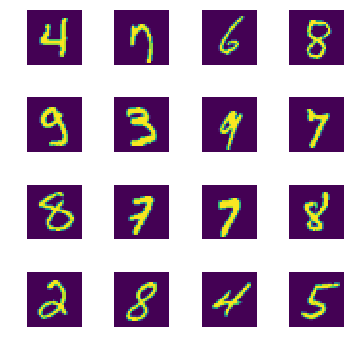

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 27 15:55:29 2017

@author: HQ
"""

import os,random
import numpy as np

from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
K.image_data_format()
#from IPython import display
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.datasets import mnist


## plotting function
### ploting
def plot_gen(n_ex=16,dim=(4,4), figsize=(5,5)):
    noise = np.random.normal(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)
    generated_images = ((generated_images * 127.5) + 127.5).astype(np.uint8)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]

        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_real(n_ex=16,dim=(4,4), figsize=(5,5)):

    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]
    generated_images = ((generated_images * 127.5) + 127.5).astype(np.uint8)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_loss(losses):
#        display.clear_output(wait=True)
#        display.display(plt.gcf())
        plt.figure(figsize=(6,4))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = (X_train.astype(np.float32) - 127.5)/127.5 ## -1 ~ 1 scaleing)
X_test = (X_test.astype(np.float32) - 127.5)/127.5

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

print(X_train.shape)

## model
## generator

g_input = Input(shape = (100,))
H = Dense(128*7*7)(g_input)
H = LeakyReLU(0.2)(H)
H = BatchNormalization()(H)
H = Reshape([7,7,128])(H)
H = UpSampling2D()(H)
H = Conv2D(64,(5,5),padding='same')(H)
H = LeakyReLU(0.2)(H)
H = BatchNormalization()(H)
H = UpSampling2D()(H)
H = Conv2D(1,(5,5),padding='same')(H)
g_V = Activation('tanh')(H)

generator = Model(inputs = g_input, outputs = g_V)
generator.compile(loss = 'binary_crossentropy', optimizer = Adam())

## discriminator

d_input = Input(shape = (X_train.shape[1:]))
H = Conv2D(64,(5,5),strides=(2,2),padding='same')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(0.3)(H)
H = Conv2D(128,(5,5),strides=(2,2), padding='same')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(0.3)(H)
H = Flatten()(H)
H = Dense(1)(H)
d_V = Activation('sigmoid')(H)

discriminator = Model(inputs = d_input, outputs = d_V)
discriminator.compile(loss = 'binary_crossentropy', optimizer= Adam())

## combine model
discriminator.trainable = False
GAN_input= Input(shape = (100,))
gen_sample = generator(GAN_input)
GAN_output = discriminator(gen_sample)

GAN = Model(inputs = GAN_input, outputs = GAN_output)
GAN.compile(loss = 'binary_crossentropy', optimizer=Adam())

##############
## train GAN model

epoch = 10
batch_size = 128
freq = 1

batch_count = X_train.shape[0]//batch_size

losses = {"d":[], "g":[]}
for i in range(epoch):
    for j in tqdm(range(batch_count)):
        noise_input = np.random.normal(0, 1, size= (batch_size, 100))

        real_image = X_train[np.random.randint(0, X_train.shape[0],
                                                size = batch_size)]

        fake_image = generator.predict(noise_input, batch_size=batch_size)

        X = np.concatenate([fake_image,real_image])
        y_discriminator = [0]*batch_size + [1] * batch_size

        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y_discriminator)
        losses["d"].append(d_loss)


        noise_input = np.random.normal(0, 1, size= (batch_size, 100))
        y_generator = [1] * batch_size
        discriminator.trainable = False
        g_loss = GAN.train_on_batch(noise_input, y_generator)
        losses["g"].append(g_loss)

    if i%freq==freq-1:
       plot_loss(losses)
       plot_gen()





plot_gen()
plot_real()